In [1]:
import librosa
import os
import os.path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Musical Similarity LSH Hashing

In [2]:
def hash_func(vecs, projections):
    bools = np.dot(vecs, projections.T) > 0
    return [bool2int(bool_vec) for bool_vec in bools]

In [3]:
def bool2int(x):
    y = 0
    for i,j in enumerate(x):
        if j: y += 1<<i
    return y

In [4]:
class Table:
    
    def __init__(self, hash_size, dim):
        self.table = dict()
        self.hash_size = hash_size
        self.projections = np.random.randn(self.hash_size, dim)

    def add(self, vecs, label):
        entry = {'label': label}
        hashes = hash_func(vecs, self.projections)
        for h in hashes:
            if self.table.__contains__(h):
                self.table[h].append(entry)
            else:
                self.table[h] = [entry]

    def query(self, vecs):
        hashes = hash_func(vecs, self.projections)
        results = list()
        for h in hashes:
            if self.table.__contains__(h):
                results.extend(self.table[h])
        return results

In [5]:
class LSH:
    def __init__(self, dim):
        self.num_tables = 4
        self.hash_size = 8
        self.tables = list()
        for i in range(self.num_tables):
            self.tables.append(Table(self.hash_size, dim))
    
    def add(self, vecs, label):
        for table in self.tables:
            table.add(vecs, label)
    
    def query(self, vecs):
        results = list()
        for table in self.tables:
            results.extend(table.query(vecs))
        return results

    def describe(self):
        for table in self.tables:
            print(table.table)

In [35]:
class MusicSearch:
    
    def __init__(self, data_files):
        self.frame_size = 4096
        self.hop_size = 4000
        self.fv_size = 12
        self.lsh = LSH(self.fv_size)
        self.data_files = data_files
        self.num_features_in_file = dict()
        for f in self.data_files:
            self.num_features_in_file[f] = 0
                
    def load(self):
        count = 0
        for filepath in self.data_files:
            print(str(count) + " / " + str(len(self.data_files)))
            x, fs = librosa.load(filepath)
            features = librosa.feature.chroma_stft(x, fs, n_fft=self.frame_size, hop_length=self.hop_size).T
            self.lsh.add(features, filepath)
            self.num_features_in_file[filepath] += len(features)
            count += 1
                
    def query(self, filepath):
        x, fs = librosa.load(filepath)
        features = librosa.feature.chroma_stft(x, fs, n_fft=self.frame_size, hop_length=self.hop_size).T
        results = self.lsh.query(features)
        # print('num results', len(results))

        counts = dict()
        for r in results:
            if counts.__contains__(r['label']):
                counts[r['label']] += 1
            else:
                counts[r['label']] = 1
        for k in counts:
            counts[k] = float(counts[k])/self.num_features_in_file[k]
        return counts

In [9]:
target_dir = 'targets/'
target_files = [os.path.join(target_dir, f) for f in os.listdir(target_dir)]

In [10]:
ms = MusicSearch(target_files)
ms.load()

0 / 1023
1 / 1023
2 / 1023
3 / 1023
4 / 1023
5 / 1023
6 / 1023
7 / 1023
8 / 1023
9 / 1023
10 / 1023
11 / 1023
12 / 1023
13 / 1023
14 / 1023
15 / 1023
16 / 1023
17 / 1023
18 / 1023
19 / 1023
20 / 1023
21 / 1023
22 / 1023
23 / 1023
24 / 1023
25 / 1023
26 / 1023
27 / 1023
28 / 1023
29 / 1023
30 / 1023
31 / 1023
32 / 1023
33 / 1023
34 / 1023
35 / 1023
36 / 1023
37 / 1023
38 / 1023
39 / 1023
40 / 1023
41 / 1023
42 / 1023
43 / 1023
44 / 1023
45 / 1023
46 / 1023
47 / 1023
48 / 1023
49 / 1023
50 / 1023
51 / 1023
52 / 1023
53 / 1023
54 / 1023
55 / 1023
56 / 1023
57 / 1023
58 / 1023
59 / 1023
60 / 1023
61 / 1023
62 / 1023
63 / 1023
64 / 1023
65 / 1023
66 / 1023
67 / 1023
68 / 1023
69 / 1023
70 / 1023
71 / 1023
72 / 1023
73 / 1023
74 / 1023
75 / 1023
76 / 1023
77 / 1023
78 / 1023
79 / 1023
80 / 1023
81 / 1023
82 / 1023
83 / 1023
84 / 1023
85 / 1023
86 / 1023
87 / 1023
88 / 1023
89 / 1023
90 / 1023
91 / 1023
92 / 1023
93 / 1023
94 / 1023
95 / 1023
96 / 1023
97 / 1023
98 / 1023
99 / 1023
100 / 1023

In [36]:
source_file = './source/source_from_220462_to_250000.wav'
sourceStart = 220462
sourceEnd = 250000
results = ms.query(source_file)

num results 11185149


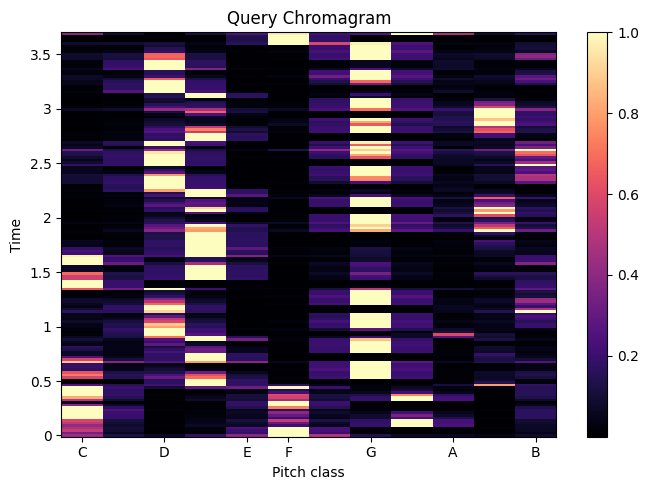

In [50]:
import librosa.display

x, fs = librosa.load("source/source_from_220462_to_250000.wav")
features = librosa.feature.chroma_stft(x, fs, n_fft=4000, hop_length=4096).T

fig, ax = plt.subplots()
img = librosa.display.specshow(features, y_axis='time', x_axis='chroma', ax=ax)
ax.set(title='Query Chromagram')
fig.colorbar(img, ax=ax)

In [34]:
import re
targetStarts = []
targetEnds = []
res = []

for r in sorted(results, key=results.get, reverse=True):
    print(r, results[r])
    targetStarts.append(int(re.findall(r'\d+', r)[1]))
    targetEnds.append(int(re.findall(r'\d+', r)[2]))
    res.append(int(results[r]))

targets/250000target_from_210353_to_239891.wav 95.23312883435582
targets/250000target_from_42753_to_72291.wav 94.920245398773
targets/250000target_from_210153_to_239691.wav 94.00613496932516
targets/250000target_from_40953_to_70491.wav 93.920245398773
targets/250000target_from_209653_to_239191.wav 93.88343558282209
targets/250000target_from_209753_to_239291.wav 93.6441717791411
targets/250000target_from_210753_to_240291.wav 93.53374233128834
targets/250000target_from_34953_to_64491.wav 93.30061349693251
targets/250000target_from_36953_to_66491.wav 93.22699386503068
targets/250000target_from_34553_to_64091.wav 93.1717791411043
targets/250000target_from_42353_to_71891.wav 93.13496932515338
targets/250000target_from_208353_to_237891.wav 93.03067484662577
targets/250000target_from_32553_to_62091.wav 92.6441717791411
targets/250000target_from_42953_to_72491.wav 92.44171779141104
targets/250000target_from_208553_to_238091.wav 92.33742331288343
targets/250000target_from_208953_to_238491.wav 9